## Load Libaries and Import necessary dataset

In [255]:
# install.packages(c("Rcpp", "rstan"))
# install.packages("prophet")

In [256]:
# Load required libraries
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)


In [257]:

# Extract deposit_levels to use it in this file
deposit_levels <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/deposit_levels.rds") # Load the data


## Data Exploration for Prophet Assumption

In [258]:
glimpse(deposit_levels)

Rows: 162
Columns: 4
$ time     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "1985Q2", "…
$ year     <dbl> 1984, 1984, 1984, 1984, 1985, 1985, 1985, 1985, 1986, 1986, 1…
$ quarter  <dbl> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1…
$ deposits <dbl> 22917.26, 23575.19, 24308.97, 24967.96, 25673.75, 26941.33, 2…


### Data Regularity and Sufficient Historical Data Expectation

In [259]:
any(is.na(deposit_levels)) # no missing values

[1] FALSE

> The time series has regular quaterly intervals and no missing values so the data regurlarity expectation is satified. 

> It also has decades worth of data so the "sufficient historical data" expectation is satisfied. 

### Presence of Trend Expectation

In [260]:
deposit_levels <- deposit_levels %>%
  mutate(
    # Step 1: Convert `time` to a proper Date column for modeling
    ds = yq(time),  # `yq()` parses "YYYYQ#" into the first day of the quarter
    
    # Step 2: Create a readable "YYYY-Q#" format as a character column
    ds_display = paste(year, paste0("Q", quarter), sep = "-")  # Combine year and quarter
    
  ) %>%
  select(-time)  # Step 3: Remove the original `time` column if no longer needed


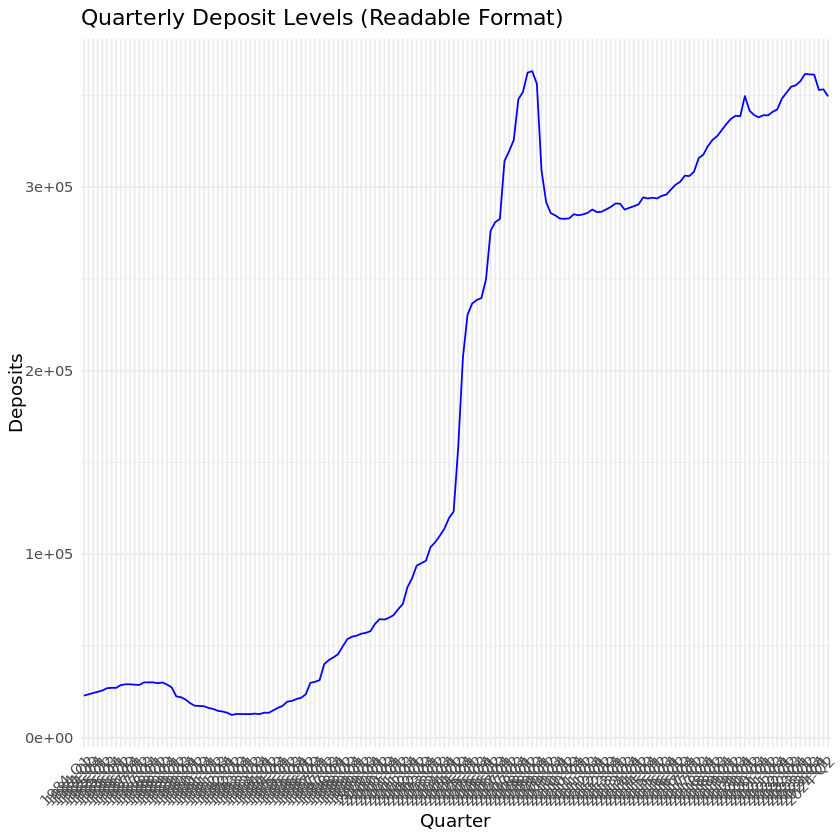

In [261]:
# Convert `ds_display` to a factor for proper ordering
deposit_levels <- deposit_levels %>%
  mutate(ds_display = factor(ds_display, levels = ds_display))  # Keeps the original order
  
# Plot using `ds_display` for a readable x-axis
ggplot(deposit_levels, aes(x = ds_display, y = deposits)) +
  geom_line(group = 1, color = "blue") +  # Add `group = 1` to connect the points
  labs(title = "Quarterly Deposit Levels (Readable Format)", x = "Quarter", y = "Deposits") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for clarity




In [262]:
glimpse(deposit_levels)

Rows: 162
Columns: 5
$ year       <dbl> 1984, 1984, 1984, 1984, 1985, 1985, 1985, 1985, 1986, 1986,…
$ quarter    <dbl> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4,…
$ deposits   <dbl> 22917.26, 23575.19, 24308.97, 24967.96, 25673.75, 26941.33,…
$ ds         <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 1985-01-01…
$ ds_display <fct> 1984-Q1, 1984-Q2, 1984-Q3, 1984-Q4, 1985-Q1, 1985-Q2, 1985-…


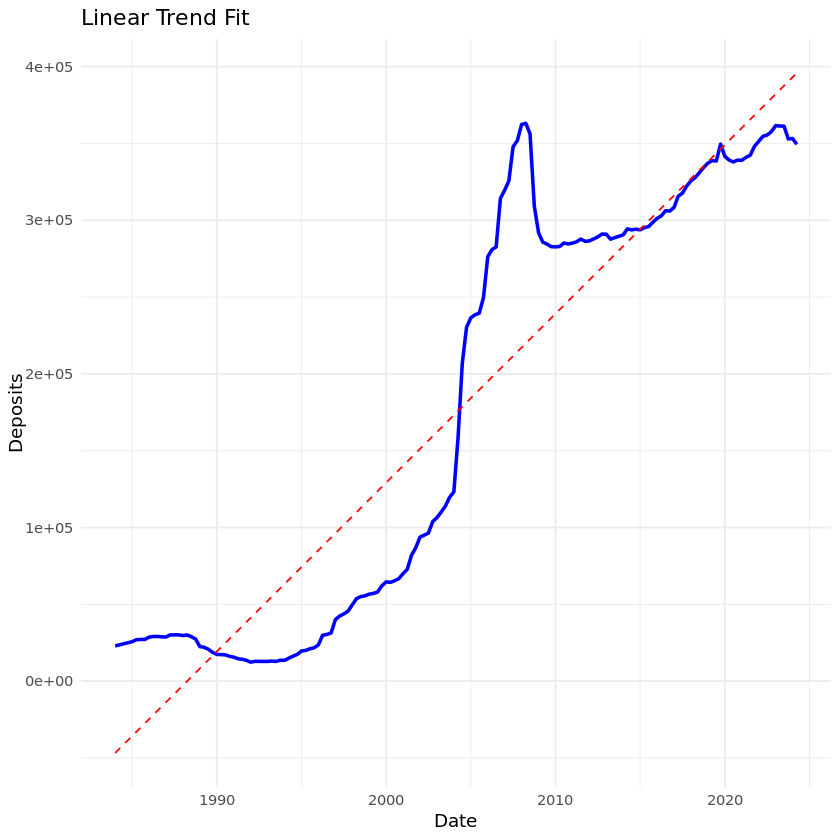

In [263]:
# Add numeric time for regression
deposit_levels <- deposit_levels %>%
  mutate(time_numeric = as.numeric(ds))  # Convert Date (ds) to numeric for regression

# Fit the linear model
linear_model <- lm(deposits ~ time_numeric, data = deposit_levels)

# Add linear trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(linear_trend = predict(linear_model))

# Plot the linear trend
library(ggplot2)
ggplot(deposit_levels, aes(x = ds, y = deposits)) +
  geom_line(color = "blue", size = 1) +  # Actual data
  geom_line(aes(y = linear_trend), color = "red", linetype = "dashed") +  # Linear trend
  labs(title = "Linear Trend Fit", x = "Date", y = "Deposits") +
  theme_minimal()


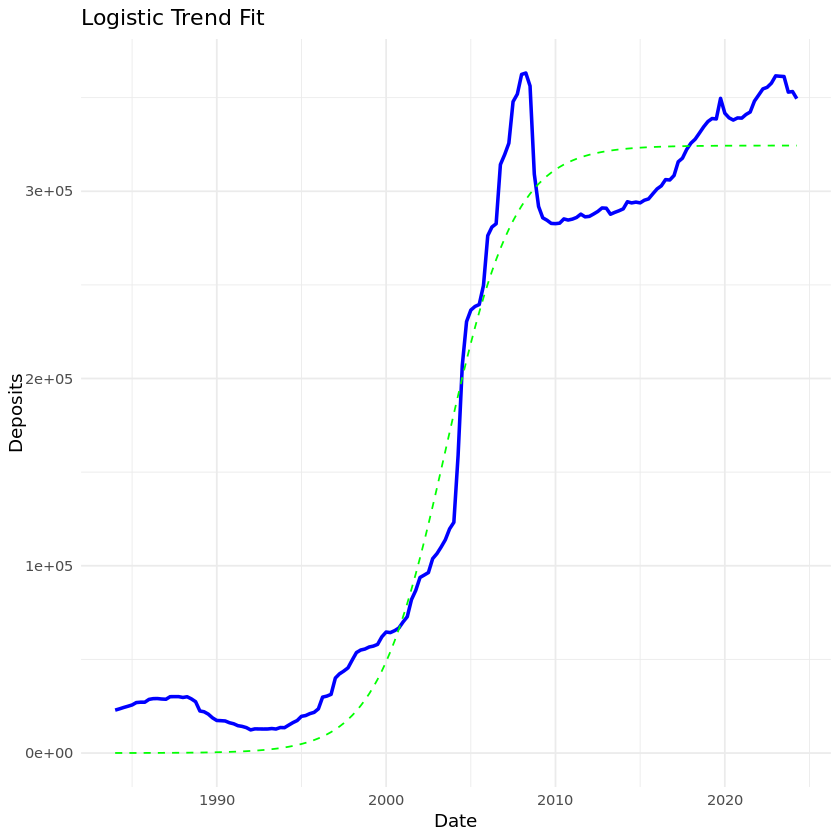

In [264]:
# Define a logistic function
logistic_function <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))  # L = carrying capacity, k = growth rate, x0 = midpoint
}

# Fit the logistic model
logistic_model <- nls(deposits ~ logistic_function(time_numeric, L, k, x0),
                      data = deposit_levels,
                      start = list(L = max(deposit_levels$deposits), k = 0.01, x0 = median(deposit_levels$time_numeric)))

# Add logistic trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(logistic_trend = predict(logistic_model))

# Plot the logistic trend
ggplot(deposit_levels, aes(x = ds, y = deposits)) +
  geom_line(color = "blue", size = 1) +  # Actual data
  geom_line(aes(y = logistic_trend), color = "green", linetype = "dashed") +  # Logistic trend
  labs(title = "Logistic Trend Fit", x = "Date", y = "Deposits") +
  theme_minimal()


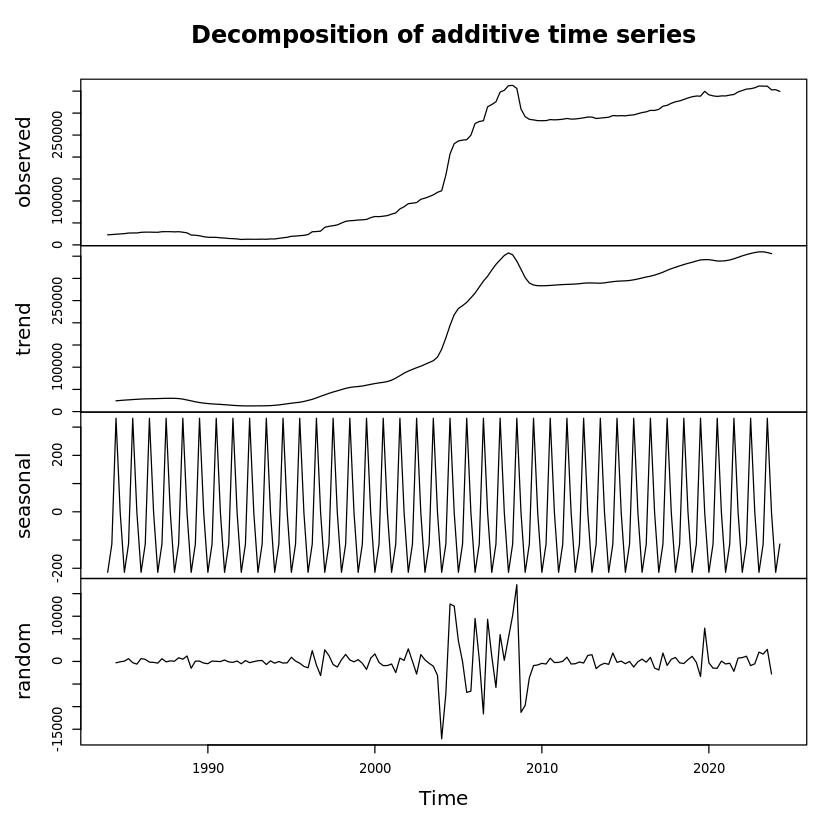

In [265]:
# Convert deposits into a time series object
library(stats)
ts_data <- ts(deposit_levels$deposits, 
              start = c(deposit_levels$year[1], deposit_levels$quarter[1]), 
              frequency = 4)  # Quarterly frequency

# Decompose the time series (additive model)
decomposition <- decompose(ts_data, type = "additive")

# Plot the decomposition
plot(decomposition)


### Seasonality

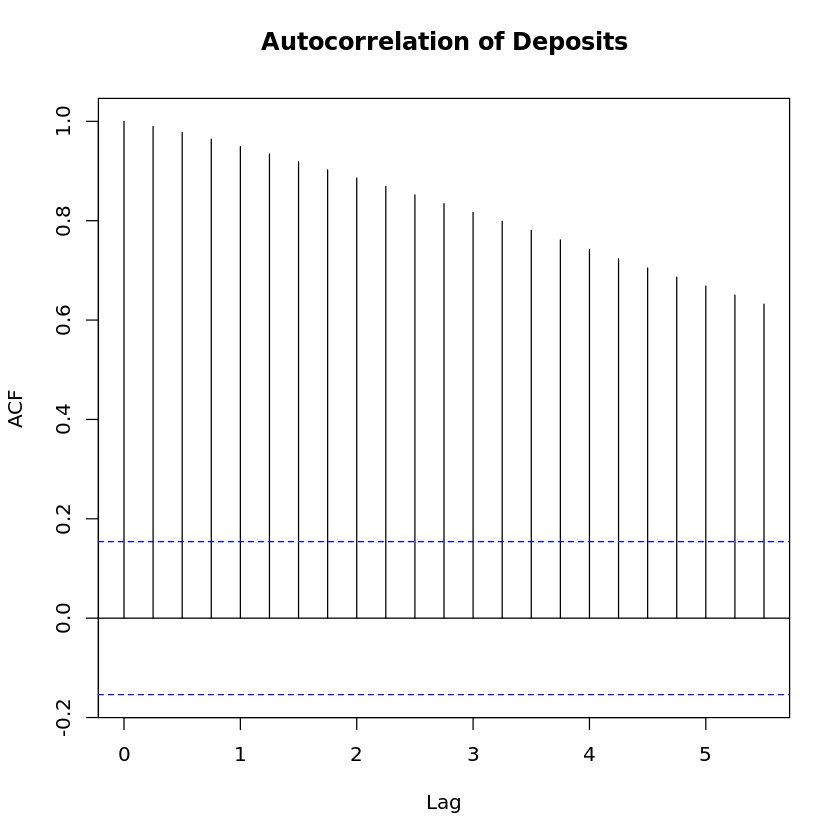

In [266]:
library(forecast)

# Plot ACF to check for seasonality
acf(ts_data, main = "Autocorrelation of Deposits")

# Look for significant spikes at lag = 4 (quarterly seasonality)


Decay pattern: Gradual decline: A slow decrease in correlation with increasing lags might indicate a trend in the data. 

Seasonal Patterns: Regularly spaced spikes at specific lags (multiples of a seasonal period) suggest seasonality in the time series. No Significant Spike at Lag 4 (Quarterly Seasonality). 
If the data had quarterly seasonality, there would be significant spikes at lag 4, lag 8, lag 12, etc.However, the absence of such spikes suggests that quarterly seasonality is weak or not present in this case.

Why no clear seasonality here?
The decomposition earlier showed a seasonal component, but the ACF does not strongly support it. This could mean:
- Dominant Trend:
The trend component (logistic growth) might be overwhelming the seasonal component, making it less apparent in the ACF.

- Weak Seasonality:
The seasonal pattern might exist but is too subtle to create significant autocorrelation spikes.

- Possible Data Noise:
Noise or external factors might be dampening the seasonal signal in the ACF

What I can do next to double check seasonality:
- Detrend the Data (Remove the Trend Component):
Since the trend dominates, remove it to isolate the seasonality. You can do this by subtracting the trend from the original data.


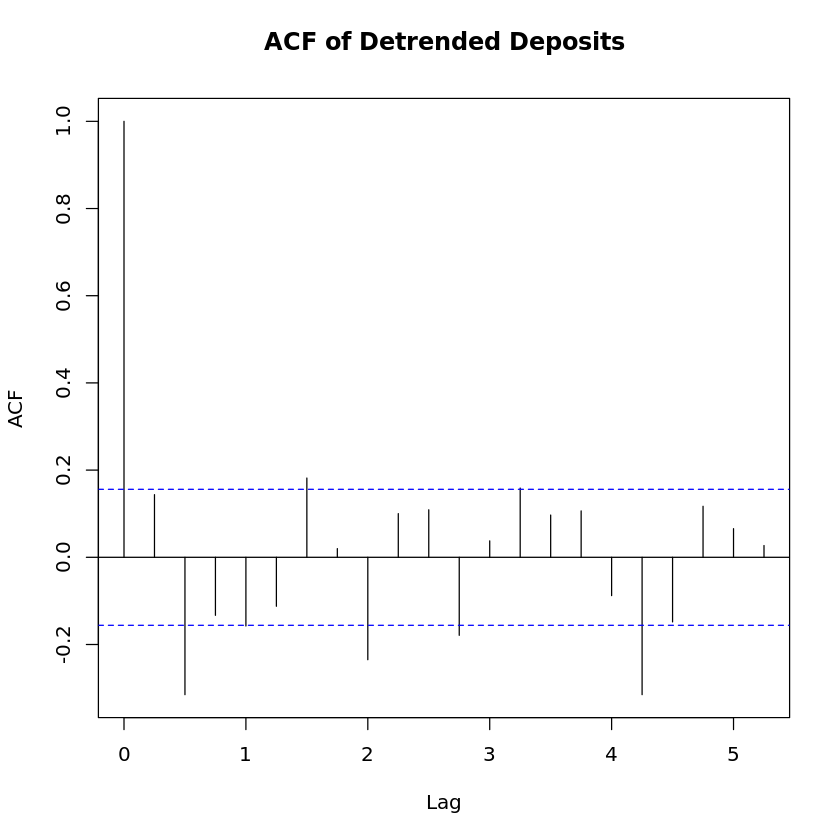

In [267]:
# Subtract the trend component, removing NA values
detrended_data <- ts_data - decomposition$trend

# Remove NA values from detrended data
detrended_data <- na.omit(detrended_data)

# Plot ACF of detrended data
acf(detrended_data, main = "ACF of Detrended Deposits")


- Based on the ACF of Detrended Deposits that you've shared, the absence of strong periodic spikes (like those at lag 4 for quarterly seasonality, lag 12 for monthly seasonality, or lag 2 for semi-annual seasonality) suggests that no other significant regular seasonality (monthly, semi-annual, etc.) is clearly present in your data.

- For now, proceed with a logistic growth model (like Prophet with growth = "logistic") and let Prophet's built-in seasonal detection handle any weak seasonal patterns

### Outliers

In [268]:
# Calculate IQR
q1 <- quantile(deposit_levels$deposits, 0.25)
q3 <- quantile(deposit_levels$deposits, 0.75)
iqr <- q3 - q1

# Define lower and upper bounds
lower_bound <- q1 - 1.5 * iqr
upper_bound <- q3 + 1.5 * iqr

# Flag outliers
outliers <- deposit_levels %>%
  filter(deposits < lower_bound | deposits > upper_bound)

# Print outliers
print(outliers)


[1] year           quarter        deposits       ds             ds_display    
[6] time_numeric   linear_trend   logistic_trend
<0 rows> (or 0-length row.names)


Based of the results, it looks like the IQR method did not flag any outliers in the data. The deposit levels in the dataset fall within the acceptable range defined by the IQR method. The deposit levels may be naturally smooth without extreme spikes or dips (maybe lol?)

### Noise

Prophet is robust to noise, but excessive noise may require preprocessing (e.g., smoothing).

In [269]:
# Calculate the variance of the residuals to quantify the noise and Compare this variance to the overall variance in the observed data.

# Variance of residuals (randomness)
residual_variance <- var(decomposition$random, na.rm = TRUE)

# Variance of the original data
observed_variance <- var(ts_data, na.rm = TRUE)

# Proportion of variance due to noise
noise_proportion <- residual_variance / observed_variance
noise_proportion


[1] 0.0006678225

- A higher proportion (close to 1) indicates the data is dominated by noise.
- A lower proportion (closer to 0) means the data has more structured patterns (e.g., trend, seasonality).

==>  Our noise proportion of approximately 0.00067 (a very small number), which means: noise contributes very little to the overall variability in your data. So there won't be any need for excessive smoothing or denoising steps. Prophet can effectively handle the low-level noise.

But for the decomposition of additive time series we clearly see randomness in our data even tho noise proportion is closer to 0. How do I include that in my prophet model to reflect the truth?

- Prophet will automatically detects changepoints in the trend. However, you can manually specify changepoints (e.g., around 2008) where the data exhibits high variability.


## Model Evaluation: Train and Test

In [270]:


# Step 1: Split the data
train <- deposit_levels[deposit_levels$ds <= "2020-12-31", ]  # Training data: 1984 Q1 to 2020 Q4
test <- deposit_levels[deposit_levels$ds > "2020-12-31" & deposit_levels$ds <= "2024-06-30", ]  # Testing data: 2021 Q1 to 2024 Q2

# Step 2: Fit Prophet on training data
m <- prophet()
m <- fit.prophet(m, train)

# Step 3: Create future dataframe for both testing and prediction periods
future <- make_future_dataframe(m, periods = 28, freq = "quarter")  # 2021 Q1 to 2028 Q1

# Step 4: Generate forecast
forecast <- predict(m, future)

# Step 5: Evaluate RMSE for testing period
forecast_test <- forecast[forecast$ds > "2020-12-31" & forecast$ds <= "2024-06-30", ]  # Testing period
rmse_value <- rmse(test$deposits, forecast_test$yhat)
print(paste("RMSE for Testing Period:", rmse_value))

# Step 6: Visualize actual vs predicted and future forecast
ggplot() +
  geom_line(data = train, aes(x = ds, y = deposits), color = "black") +  # Training actuals
  geom_line(data = test, aes(x = ds, y = deposits), color = "blue", linetype = "dashed") +  # Testing actuals
  geom_line(data = forecast, aes(x = ds, y = yhat), color = "red") +  # Predictions (testing + future)
  labs(title = "Actual vs Predicted Deposits (Including Future Forecast)",
       x = "Date", y = "Deposits") +
  theme_minimal()

# Step 7: Display future forecast (2024 Q3 to 2028 Q1)
forecast_future <- forecast[forecast$ds > "2024-06-30", ]  # Future prediction period
print(forecast_future[, c("ds", "yhat", "yhat_lower", "yhat_upper")])


ERROR: Error in fit.prophet(m, train): Dataframe must have columns 'ds' and 'y' with the dates and values respectively.
